imports

In [ ]:
import json
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

opening the json file

In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

In [4]:
# Initializing the lists

sentences = []
labels = []

# Collect sentences and labels into the lists

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

hyperparameters

In [5]:
# Number of examples to use for training

TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer

VOCAB_SIZE = 10000

# Maximum length of the padded sequences

MAX_LENGTH = 32

# Output dimensions of the Embedding layer

EMBEDDING_DIM = 16

splitting the dataset

In [6]:
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

pre-processing the training and testing dataset

In [7]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)

vectorize_layer.adapt(train_sentences)

I0000 00:00:1755237304.749855   20406 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1157 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
train_sequences = vectorize_layer(train_sentences)
test_sequences = vectorize_layer(test_sentences)

In [9]:
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences,train_labels))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences,test_labels))

sanity check

In [10]:
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 319,    1,  943, 4079, 2366,   47,  366,   94, 2026,    6, 2653,
       9470,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([   4, 7185, 3128, 3305,   28,    2,  152,    1,  358, 2902,    6,
        236,    9,  844,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



2025-08-15 11:30:29.194597: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


optimizing and batching

In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

building the final model

In [12]:
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

sample_array = np.array([[[10,2],[1,3],[1,1]]])

print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

output = gap1d_layer(sample_array)

print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4. 2.]]


In [13]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,433 (626.69 KB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

using the other approach instead of tf.keras.layers.Flatten()

In [14]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

training the model

In [15]:
num_epochs = 10

history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final, verbose=2)

Epoch 1/10


I0000 00:00:1755237937.904291   20571 service.cc:152] XLA service 0x7f9d3c05eb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755237937.904312   20571 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-15 11:35:37.920341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755237938.020902   20571 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1755237938.568674   20571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 - 3s - 4ms/step - accuracy: 0.6880 - loss: 0.5753 - val_accuracy: 0.8174 - val_loss: 0.4264
Epoch 2/10
625/625 - 1s - 1ms/step - accuracy: 0.8573 - loss: 0.3496 - val_accuracy: 0.8442 - val_loss: 0.3629
Epoch 3/10
625/625 - 1s - 1ms/step - accuracy: 0.8932 - loss: 0.2689 - val_accuracy: 0.8496 - val_loss: 0.3537
Epoch 4/10
625/625 - 1s - 1ms/step - accuracy: 0.9151 - loss: 0.2224 - val_accuracy: 0.8286 - val_loss: 0.4023
Epoch 5/10
625/625 - 1s - 1ms/step - accuracy: 0.9283 - loss: 0.1902 - val_accuracy: 0.8426 - val_loss: 0.3866
Epoch 6/10
625/625 - 1s - 1ms/step - accuracy: 0.9394 - loss: 0.1663 - val_accuracy: 0.8483 - val_loss: 0.3931
Epoch 7/10
625/625 - 1s - 1ms/step - accuracy: 0.9470 - loss: 0.1467 - val_accuracy: 0.8429 - val_loss: 0.4263
Epoch 8/10
625/625 - 1s - 1ms/step - accuracy: 0.9539 - loss: 0.1297 - val_accuracy: 0.8435 - val_loss: 0.4422
Epoch 9/10
625/625 - 1s - 1ms/step - accuracy: 0.9589 - loss: 0.1161 - val_accuracy: 0.8416 - val_loss: 0.4739
Epoch 10/10


visualizing the results

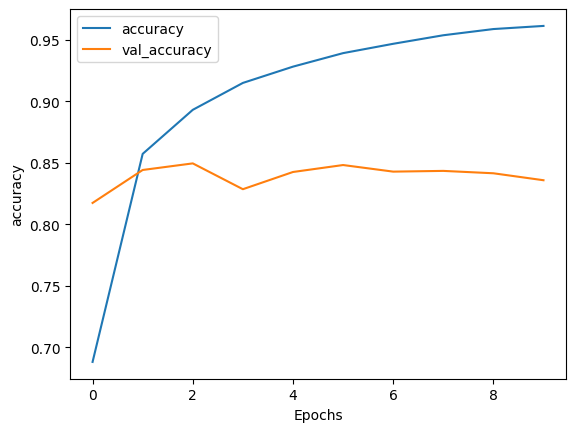

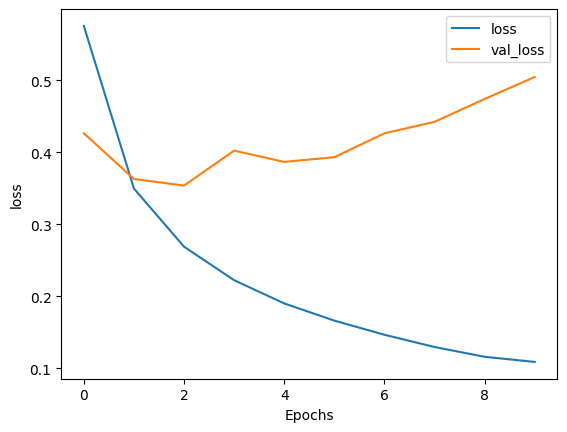

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

visualize the embeddings

In [17]:
embedding_layer = model.layers[0]

embedding_weights = embedding_layer.get_weights()[0]

print(embedding_weights.shape)

(10000, 16)


In [ ]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

vocabulary = vectorize_layer.get_vocabulary()

for word_num in range(1, len(vocabulary)):

  word_name = vocabulary[word_num]

  word_embedding = embedding_weights[word_num]

  out_m.write(word_name + "\n")

  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

out_v.close()
out_m.close()